# 1. Importing modules and functions

In [1]:
import numpy as np
import pandas as pd
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Descriptors
from rdkit.Chem import MACCSkeys
from copy import deepcopy
from rdkit.ML.Descriptors import MoleculeDescriptors
from molvs import standardize_smiles
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.model_selection import permutation_test_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict
from sklearn import metrics
from sklearn.metrics import pairwise_distances
import joblib
import pickle
from numpy import savetxt
from padelpy import from_sdf
from IPython.display import HTML
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from padelpy import from_sdf
import shap
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
def convert_smi_to_canon_smi(smi):
    
    try:
        canon_smi = Chem.MolToSmiles(Chem.MolFromSmiles(smi),isomericSmiles = False)
    except:
        canon_smi='wrong_smiles'
    return canon_smi

In [3]:
def standart(smi):
    global m
    if smi!='wrong_smiles':
        try:
            smiles=standardize_smiles(smi)
            m = Chem.MolFromSmiles(smi)
        except:
            smi='error kekule'
    else:
        m = 'check the smiles'
    return m

## Load data and curation work set

In [4]:
# Set file path
df_ws=pd.read_csv('rat_oral_LD50_WS.csv')
df_ws

,CAS_Number,SMILES,pLD50,"LD50,mg/kg"
0,626-48-2,Cc1cc(=O)[nH]c(=O)[nH]1,0.291207,64463.0000
1,27849-94-1,CC(CCc1ccc2c(c1)OCO2)NN,0.440660,75449.0000
2,110-54-3,CCCCCC,0.537460,24980.0000
3,1330-92-3,CCCCC(CC)COC(=O)C1=C(C(=O)OCC(CC)CCCC)CCCC1,0.539250,113917.0000
4,57-55-6,CC(O)CO,0.580330,19989.0000
...,...,...,...,...
7707,56073-10-0,O=c1oc2ccccc2c(O)c1C1CC(c2ccc(-c3ccc(Br)cc3)cc...,6.514700,0.1596
7708,130209-82-4,CC(C)OC(=O)CCC/C=C/CC1C(O)CC(O)C1CCC(O)CCc1ccccc1,6.937100,0.0500
7709,83805-11-2,C=C1/C(=C\C=C2/CCCC3(C)C2CCC3C(C)CCCC(O)(C(F)(...,7.099700,0.0417
7710,1746-01-6,Clc1cc2c(cc1Cl)Oc1cc(Cl)c(Cl)cc1O2,7.206800,0.0199


 Convert a SMILES string to canonical SMILES

In [5]:
df_ws1 = deepcopy(df_ws)
df_ws1["SMILES"] = df_ws1.apply(lambda x: convert_smi_to_canon_smi(x.SMILES), axis=1)
df_ws1

,CAS_Number,SMILES,pLD50,"LD50,mg/kg"
0,626-48-2,Cc1cc(=O)[nH]c(=O)[nH]1,0.291207,64463.0000
1,27849-94-1,CC(CCc1ccc2c(c1)OCO2)NN,0.440660,75449.0000
2,110-54-3,CCCCCC,0.537460,24980.0000
3,1330-92-3,CCCCC(CC)COC(=O)C1=C(C(=O)OCC(CC)CCCC)CCCC1,0.539250,113917.0000
4,57-55-6,CC(O)CO,0.580330,19989.0000
...,...,...,...,...
7707,56073-10-0,O=c1oc2ccccc2c(O)c1C1CC(c2ccc(-c3ccc(Br)cc3)cc...,6.514700,0.1596
7708,130209-82-4,CC(C)OC(=O)CCCC=CCC1C(O)CC(O)C1CCC(O)CCc1ccccc1,6.937100,0.0500
7709,83805-11-2,C=C1C(=CC=C2CCCC3(C)C2CCC3C(C)CCCC(O)(C(F)(F)F...,7.099700,0.0417
7710,1746-01-6,Clc1cc2c(cc1Cl)Oc1cc(Cl)c(Cl)cc1O2,7.206800,0.0199


In [6]:
print('Original data: ', len(df_ws), 'molecules')
print('Failed data: ', len(df_ws1[df_ws1['SMILES']=='wrong_smiles']), 'molecules')

Original data:  7712 molecules
Failed data:  0 molecules


In [7]:
index=df_ws1.index[df_ws1['SMILES']=='wrong_smiles'].tolist()
wrong_smiles=df_ws.iloc[index]
wrong_smiles=wrong_smiles.SMILES
number=[x+1 for x in index]
bad_molecules = pd.DataFrame({'No. failed smiles in original set': number, 'SMILES of wrong structure: ': wrong_smiles}, index=None)
bad_molecules = bad_molecules.set_index('No. failed smiles in original set')
bad_molecules

,SMILES of wrong structure:
No. failed smiles in original set,


##  Standardization  for work set

In [8]:
df_ws1["Molecule"] = df_ws1.apply(lambda x: standart(x.SMILES), axis=1)
moldf_ws=df_ws1[df_ws1['SMILES']!='wrong_smiles']
print('Kept data: ', len(moldf_ws), 'molecules')

Kept data:  7712 molecules


In [9]:
moldf_ws

,CAS_Number,SMILES,pLD50,"LD50,mg/kg",Molecule
0,626-48-2,Cc1cc(=O)[nH]c(=O)[nH]1,0.291207,64463.0000,<rdkit.Chem.rdchem.Mol object at 0x000001AFFC3...
1,27849-94-1,CC(CCc1ccc2c(c1)OCO2)NN,0.440660,75449.0000,<rdkit.Chem.rdchem.Mol object at 0x000001AFFC3...
2,110-54-3,CCCCCC,0.537460,24980.0000,<rdkit.Chem.rdchem.Mol object at 0x000001AFFC3...
3,1330-92-3,CCCCC(CC)COC(=O)C1=C(C(=O)OCC(CC)CCCC)CCCC1,0.539250,113917.0000,<rdkit.Chem.rdchem.Mol object at 0x000001AFFC3...
4,57-55-6,CC(O)CO,0.580330,19989.0000,<rdkit.Chem.rdchem.Mol object at 0x000001AFFCC...
...,...,...,...,...,...
7707,56073-10-0,O=c1oc2ccccc2c(O)c1C1CC(c2ccc(-c3ccc(Br)cc3)cc...,6.514700,0.1596,<rdkit.Chem.rdchem.Mol object at 0x000001AFFC5...
7708,130209-82-4,CC(C)OC(=O)CCCC=CCC1C(O)CC(O)C1CCC(O)CCc1ccccc1,6.937100,0.0500,<rdkit.Chem.rdchem.Mol object at 0x000001AFFC5...
7709,83805-11-2,C=C1C(=CC=C2CCCC3(C)C2CCC3C(C)CCCC(O)(C(F)(F)F...,7.099700,0.0417,<rdkit.Chem.rdchem.Mol object at 0x000001AFFC5...
7710,1746-01-6,Clc1cc2c(cc1Cl)Oc1cc(Cl)c(Cl)cc1O2,7.206800,0.0199,<rdkit.Chem.rdchem.Mol object at 0x000001AFFC5...


In [10]:
y_tr=moldf_ws.pLD50
y_tr

0       0.291207
1       0.440660
2       0.537460
3       0.539250
4       0.580330
          ...   
7707    6.514700
7708    6.937100
7709    7.099700
7710    7.206800
7711    7.602600
Name: pLD50, Length: 7712, dtype: float64

In [11]:
moldf_ws=moldf_ws.Molecule

##  Load data and curation test set

In [12]:
df_ts=pd.read_csv('rat_oral_LD50_TS.csv')
df_ts

,CAS_Number,SMILES,pLD50,"LD50,mg/kg"
0,7782-40-3,C,0.017765,15388.8000
1,2842-38-8,OCCNC1CCCCC1,0.572840,38274.0000
2,66257-53-2,NC(=O)C(=O)O,0.624490,21133.0000
3,2173-56-0,CCCCCOC(=O)CCCC,0.686960,35395.0000
4,4726-93-6,O=C1CCCCC(=O)N1,0.750180,22586.0000
...,...,...,...,...
1924,3385-03-3,CC1(C)OC2CC3C4CC(F)C5=CC(=O)C=CC5(C)C4C(O)CC3(...,5.939000,0.4997
1925,2338-29-6,FC(F)(F)c1nc2c(Cl)c(Cl)c(Cl)c(Cl)c2[nH]1,6.121300,0.2435
1926,128606-48-4,CCOP(=S)(OCC)O/C(C)=C/C(=O)OC,6.282400,0.1399
1927,50585-41-6,Brc1cc2c(cc1Br)Oc1cc(Br)c(Br)cc1O2,6.698800,0.0992


 Convert a SMILES string to canonical SMILES

In [13]:
df_ts1 = deepcopy(df_ts)
df_ts1["SMILES"] = df_ts1.apply(lambda x: convert_smi_to_canon_smi(x.SMILES), axis=1)
df_ts1

,CAS_Number,SMILES,pLD50,"LD50,mg/kg"
0,7782-40-3,C,0.017765,15388.8000
1,2842-38-8,OCCNC1CCCCC1,0.572840,38274.0000
2,66257-53-2,NC(=O)C(=O)O,0.624490,21133.0000
3,2173-56-0,CCCCCOC(=O)CCCC,0.686960,35395.0000
4,4726-93-6,O=C1CCCCC(=O)N1,0.750180,22586.0000
...,...,...,...,...
1924,3385-03-3,CC1(C)OC2CC3C4CC(F)C5=CC(=O)C=CC5(C)C4C(O)CC3(...,5.939000,0.4997
1925,2338-29-6,FC(F)(F)c1nc2c(Cl)c(Cl)c(Cl)c(Cl)c2[nH]1,6.121300,0.2435
1926,128606-48-4,CCOP(=S)(OCC)OC(C)=CC(=O)OC,6.282400,0.1399
1927,50585-41-6,Brc1cc2c(cc1Br)Oc1cc(Br)c(Br)cc1O2,6.698800,0.0992


In [14]:
print('Original data: ', len(df_ts), 'molecules')
print('Failed data: ', len(df_ts1[df_ts1['SMILES']=='wrong_smiles']), 'molecules')

Original data:  1929 molecules
Failed data:  0 molecules


In [15]:
index=df_ts1.index[df_ts1['SMILES']=='wrong_smiles'].tolist()
wrong_smiles=df_ts.iloc[index]
wrong_smiles=wrong_smiles.SMILES
number=[x+1 for x in index]
bad_molecules = pd.DataFrame({'No. failed smiles in original set': number, 'SMILES of wrong structure: ': wrong_smiles}, index=None)
bad_molecules = bad_molecules.set_index('No. failed smiles in original set')
bad_molecules

,SMILES of wrong structure:
No. failed smiles in original set,


##  Standardization  for test set

In [16]:
df_ts1["Molecule"] = df_ts1.apply(lambda x: standart(x.SMILES), axis=1)
moldf_ts=df_ts1[df_ts1['SMILES']!='wrong_smiles']
print('Kept data: ', len(moldf_ts), 'molecules')

Kept data:  1929 molecules


In [17]:
moldf_ts

,CAS_Number,SMILES,pLD50,"LD50,mg/kg",Molecule
0,7782-40-3,C,0.017765,15388.8000,<rdkit.Chem.rdchem.Mol object at 0x000001AFFC3...
1,2842-38-8,OCCNC1CCCCC1,0.572840,38274.0000,<rdkit.Chem.rdchem.Mol object at 0x000001AFFC3...
2,66257-53-2,NC(=O)C(=O)O,0.624490,21133.0000,<rdkit.Chem.rdchem.Mol object at 0x000001AFFC3...
3,2173-56-0,CCCCCOC(=O)CCCC,0.686960,35395.0000,<rdkit.Chem.rdchem.Mol object at 0x000001AFFC3...
4,4726-93-6,O=C1CCCCC(=O)N1,0.750180,22586.0000,<rdkit.Chem.rdchem.Mol object at 0x000001AFFC3...
...,...,...,...,...,...
1924,3385-03-3,CC1(C)OC2CC3C4CC(F)C5=CC(=O)C=CC5(C)C4C(O)CC3(...,5.939000,0.4997,<rdkit.Chem.rdchem.Mol object at 0x000001AFFC5...
1925,2338-29-6,FC(F)(F)c1nc2c(Cl)c(Cl)c(Cl)c(Cl)c2[nH]1,6.121300,0.2435,<rdkit.Chem.rdchem.Mol object at 0x000001AFFC5...
1926,128606-48-4,CCOP(=S)(OCC)OC(C)=CC(=O)OC,6.282400,0.1399,<rdkit.Chem.rdchem.Mol object at 0x000001AFFC5...
1927,50585-41-6,Brc1cc2c(cc1Br)Oc1cc(Br)c(Br)cc1O2,6.698800,0.0992,<rdkit.Chem.rdchem.Mol object at 0x000001AFFC5...


In [18]:
y_ts=moldf_ts.pLD50
y_ts

0       0.017765
1       0.572840
2       0.624490
3       0.686960
4       0.750180
          ...   
1924    5.939000
1925    6.121300
1926    6.282400
1927    6.698800
1928    9.541100
Name: pLD50, Length: 1929, dtype: float64

In [19]:
moldf_ts=moldf_ts.Molecule

# Calculation RDKit_2D descriptors for work set

In [20]:
calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
header = calc.GetDescriptorNames()

In [21]:
descr_tr= []
for m in moldf_ws:
    descr_tr.append(calc.CalcDescriptors(m))
x_tr = np.asarray(descr_tr)

In [22]:
df_RDKit_2D = pd.DataFrame(x_tr,columns=header)

In [23]:
df_RDKit_2D.head(2)

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,10.435556,10.435556,0.364583,-0.458333,0.485781,126.115,120.067,126.042927,48.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5.331682,5.331682,0.329095,0.329095,0.576369,208.261,192.133,208.121178,82.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
df_RDKit_2D.isna().mean().sort_values(ascending=False)

BCUT2D_MWLOW        0.000259
MaxPartialCharge    0.000259
BCUT2D_CHGLO        0.000259
BCUT2D_CHGHI        0.000259
BCUT2D_MRHI         0.000259
                      ...   
SlogP_VSA8          0.000000
SlogP_VSA9          0.000000
TPSA                0.000000
EState_VSA1         0.000000
fr_urea             0.000000
Length: 209, dtype: float64

In [25]:
df_RDKit_2D=df_RDKit_2D.dropna(axis=1)
df_RDKit_2D

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,10.435556,10.435556,0.364583,-0.458333,0.485781,126.115,120.067,126.042927,48.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5.331682,5.331682,0.329095,0.329095,0.576369,208.261,192.133,208.121178,82.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.231806,2.231806,1.355000,1.355000,0.462954,86.178,72.066,86.109550,38.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,12.654921,12.654921,0.305905,-0.305905,0.320912,394.596,352.260,394.308310,162.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,8.111111,8.111111,0.138889,-0.560185,0.435835,76.095,68.031,76.052429,32.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7707,13.101706,13.101706,0.030453,-0.465519,0.245754,523.426,500.242,522.083057,172.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7708,11.543842,11.543842,0.006523,-0.513401,0.247186,432.601,392.281,432.287574,174.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
7709,13.011064,13.011064,0.077001,-5.771605,0.335502,524.586,486.282,524.272514,206.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7710,5.914545,5.914545,0.391229,0.391229,0.490572,321.974,317.942,319.896540,92.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
x_tr= df_RDKit_2D.to_numpy ()

In [27]:
# Data Standardization
from sklearn.preprocessing import StandardScaler
scale = StandardScaler().fit(x_tr)
x_tr = scale.transform(x_tr)


In [28]:
x_tr.shape

(7712, 197)

In [29]:
savetxt('models/RDKiT/x_tr_RDKiT.csv', x_tr, delimiter=',')

# Calculation RDKit_2D descriptors for test set

In [30]:
descr_ts = []
for m in moldf_ts:
    descr_ts.append(calc.CalcDescriptors(m))
x_ts = np.asarray(descr_ts)

In [31]:
x_ts.shape

(1929, 209)

In [32]:
df_RDKit_2D_ts = pd.DataFrame(x_ts,columns=header)
df_RDKit_2D_ts=df_RDKit_2D_ts.dropna(axis=1)
df_RDKit_2D_ts

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,0.000000,0.000000,0.000000,0.000000,0.359785,16.043,12.011,16.031300,8.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,8.534403,8.534403,0.274306,0.274306,0.614964,143.230,126.094,143.131014,60.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,9.321759,9.321759,1.324074,-1.601852,0.356333,89.050,86.026,89.011293,34.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10.942870,10.942870,0.034303,-0.034303,0.435733,172.268,152.108,172.146330,72.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
4,10.561528,10.561528,0.127315,-0.127315,0.472430,127.143,118.071,127.063329,50.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1924,15.445723,15.445723,0.124858,-1.371957,0.692771,434.504,403.256,434.210467,170.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1925,12.444734,12.444734,0.098711,-4.634295,0.523911,323.916,322.908,321.884593,92.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1926,10.941895,10.941895,0.316744,-2.784901,0.305670,268.271,251.135,268.053431,94.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1927,5.822407,5.822407,0.686849,0.686849,0.345378,499.778,495.746,495.694478,92.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
x_ts= df_RDKit_2D_ts.to_numpy ()

In [34]:
x_ts = scale.transform(x_ts)

In [35]:
x_ts.shape

(1929, 197)

 ## GradientBoostingRegressor model building and validation

In [37]:
seed = 42

In [38]:
cv=KFold(n_splits=5, random_state=seed, shuffle=True)

In [39]:
param_grid = {'learning_rate': [0.02,0.05],
                  'subsample'    : [0.9, 0.5, 0.1],
                  'n_estimators' : [100,500,1000],
                  'max_depth'    : [4, 10]
                 }

In [49]:
m = GridSearchCV(GradientBoostingRegressor(), param_grid, n_jobs=-1, cv=cv, verbose=1)

In [43]:
m.fit(x_tr, y_tr)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.02, 0.05], 'max_depth': [4, 10],
                         'n_estimators': [100, 500, 1000],
                         'subsample': [0.9, 0.5, 0.1]},
             verbose=1)

In [51]:
best_GBR = m.best_estimator_

In [52]:
m.best_params_

{'learning_rate': 0.02, 'max_depth': 10, 'n_estimators': 500, 'subsample': 0.5}

In [53]:
y_pred_ws_GBR = best_GBR.predict(x_tr)

In [54]:
R2_WS = round(r2_score(y_tr, y_pred_ws_GBR), 2)
R2_WS

0.98

In [55]:
RMSE_WS=round(np.sqrt(mean_absolute_error(y_tr, y_pred_ws_GBR)), 2)
RMSE_WS

0.33

In [56]:
y_pred_CV_GBR = cross_val_predict(best_GBR, x_tr, y_tr, cv=cv)

In [57]:
Q2_CV = round(r2_score(y_tr, y_pred_CV_GBR), 2)
Q2_CV

0.59

In [58]:
RMSE_CV=round(np.sqrt(mean_absolute_error(y_tr, y_pred_CV_GBR)), 2)
RMSE_CV

0.64

# 9. Prediction for test set's molecules

In [59]:
x_ts = np.array(x_ts, dtype=np.float32)
y_ts = np.array(y_ts, dtype=np.float32)
len(y_ts)

1929

In [60]:
y_pred_GBR = best_GBR.predict(x_ts)

In [61]:
Q2_TS = round(r2_score(y_ts, y_pred_GBR), 2)
Q2_TS

0.59

In [62]:
RMSE_TS=round(np.sqrt(mean_absolute_error(y_ts, y_pred_GBR)), 2)
RMSE_TS

0.64

# save the model to disk

In [63]:
pickle.dump(best_GBR, open('models/RDKiT/Toxicity_GBR_RDKiT.pkl', 'wb'))

# load the model from disk

In [20]:
best_GBR = pickle.load(open('models/RDKiT/Toxicity_GBR_RDKiT.pkl', 'rb'))

# 10. Y-randomization GradientBoostingRegressor model

In [58]:
permutations = 50
score, permutation_scores, pvalue = permutation_test_score(best_GBR, x_tr, y_tr,
                                                           cv=cv, scoring='r2',
                                                           n_permutations=permutations,
                                                           n_jobs=-1,
                                                           verbose=1,
                                                           random_state=seed)
print('True score = ', score.round(2),
      '\nY-randomization = ', np.mean(permutation_scores).round(2),
      '\np-value = ', pvalue.round(4))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed: 63.1min


True score =  0.59 
Y-randomization =  -0.12 
p-value =  0.0196


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 114.1min finished


# 11. Estimating applicability domain. Method - Euclidian distances, K=1

In [64]:
neighbors_k= pairwise_distances(x_tr, n_jobs=-1)
neighbors_k.sort(0)

In [65]:
df_tr=pd.DataFrame(neighbors_k)
df_tr

,0,1,2,3,4,5,6,7,8,9,...,7702,7703,7704,7705,7706,7707,7708,7709,7710,7711
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2.562488,6.832703,1.448362,4.681631,1.562480,2.661715,3.361996,5.787035,1.376064,3.669759,...,3.628012,2.261819,4.167718,8.600130,0.935955,2.519106,8.945021,13.855372,3.890718,8.905823
2,3.164496,7.323948,3.623594,4.999512,1.813125,3.018221,4.442691,6.076381,1.439991,4.800105,...,3.890718,3.550948,5.021064,8.694206,6.705638,4.227654,9.911580,13.920907,6.770072,8.913528
3,3.294469,7.935054,3.805816,5.718753,2.382169,3.436536,5.167877,6.184614,1.474926,5.354136,...,6.002839,3.556891,10.329050,8.869283,9.566367,5.794198,9.965301,13.927616,6.855199,10.449749
4,3.489494,8.309059,3.841268,6.123028,2.578850,3.915887,5.737502,6.276516,1.600469,6.016169,...,7.384877,3.615280,10.482573,10.078299,9.666793,8.600130,9.999884,14.100402,8.544723,10.476759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7707,75.133698,73.556090,78.585971,70.308503,76.866400,75.451438,75.169849,73.197261,75.075458,78.594127,...,72.505018,74.706794,68.529534,69.624848,73.921960,69.174428,68.071384,69.826393,72.995622,69.702880
7708,76.932624,73.610367,78.936545,71.087843,77.549940,76.259993,75.810369,73.289557,75.769468,78.765302,...,74.489957,75.604897,70.805419,72.282074,74.412062,71.555304,70.606372,72.112741,74.837928,72.165241
7709,80.805735,79.391259,83.519863,74.630181,82.746572,80.567789,80.477897,78.807718,79.772532,82.808969,...,80.806368,79.495811,71.829010,73.575325,78.844489,75.966021,72.914635,72.653164,81.081395,74.516930
7710,93.912378,91.540413,94.638615,90.564006,91.996302,92.527175,92.713480,90.560569,92.951683,94.317355,...,91.521122,92.183459,86.751036,88.392417,90.246292,90.134937,85.907759,84.817102,91.571177,86.234405


In [66]:
similarity= neighbors_k

In [67]:
Dmean=np.mean(similarity[1,:])

In [68]:
round(Dmean, 2)

4.84

In [69]:
std=np.std(similarity[1,:])

In [70]:
round(std, 2)

3.48

In [71]:
model_AD_limit=Dmean+std*0.5
print(np.round(model_AD_limit, 2))

6.57


In [72]:
neighbors_k_ts= pairwise_distances(x_tr,Y=x_ts, n_jobs=-1)
neighbors_k_ts.sort(0)

In [73]:
x_ts_AD=pd.DataFrame(neighbors_k_ts)
x_ts_AD

,0,1,2,3,4,5,6,7,8,9,...,1919,1920,1921,1922,1923,1924,1925,1926,1927,1928
0,5.465819,3.063434,6.120520,1.215571,2.042183,1.515443,2.124263,1.025725,4.140815,6.195718,...,9.535378,6.718344,0.912277,3.417354,1.532195,5.493381,2.651548,3.937430,10.205494,10.943144
1,6.234664,3.486255,6.871261,1.274003,5.930919,1.834408,2.180423,4.632574,4.397817,6.286961,...,11.123143,8.086902,2.671876,4.956988,3.593117,5.741385,3.174836,4.261122,11.111793,11.040162
2,6.316803,3.733498,7.515488,1.471028,6.743273,1.948316,2.341627,4.793577,4.413711,6.723029,...,11.550254,8.196785,3.332332,4.981049,3.793641,6.125422,3.721587,4.628936,11.131279,11.288966
3,6.585389,4.169236,7.611287,1.482657,7.055424,2.380174,2.449700,5.243902,5.187092,6.844853,...,11.834881,9.029393,3.756933,5.153448,4.067074,6.232123,4.140182,4.668678,11.291831,11.433518
4,6.864812,4.318012,7.676110,1.539164,7.311141,2.622992,2.538964,5.825663,5.944842,7.037389,...,12.291220,9.363354,3.890703,5.395340,4.550949,6.623514,4.852862,4.695897,11.499324,11.473860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7707,80.338922,75.194374,74.820079,75.398762,75.141938,75.828034,74.448412,78.920279,73.853882,72.822870,...,70.320738,69.638145,73.015037,73.793203,73.584213,70.396721,73.250971,72.925727,72.262273,70.724559
7708,80.582292,75.874683,76.201353,75.984012,75.365956,76.498190,74.928930,79.056085,74.998817,73.314832,...,72.115851,70.937325,73.894682,74.797006,74.512838,73.053279,74.105870,73.897760,73.987772,72.474029
7709,85.610583,80.624788,81.426791,80.106681,79.355877,81.527688,79.109101,83.911801,80.073310,78.203852,...,72.845865,75.089405,78.752501,78.260727,77.933894,73.650932,79.158358,77.637680,79.799729,73.208492
7710,95.580120,91.566371,93.381943,93.038977,91.886781,91.586688,92.722557,94.148698,88.187959,91.504208,...,85.461066,87.054621,91.851129,92.173394,91.186276,83.418615,92.256111,91.054589,91.296886,87.232108


In [74]:
similarity_ts= neighbors_k_ts
cpd_AD=similarity_ts[0,:]
cpd_value = np.round(cpd_AD, 3)
print(cpd_value)

[ 5.466  3.063  6.121 ...  3.937 10.205 10.943]


In [75]:
cpd_AD = np.where(cpd_value <= model_AD_limit, True, False)
print(cpd_AD)

[ True  True  True ...  True False False]


In [76]:
print("Coverage = ", round(sum(cpd_AD) / len(cpd_AD), 2))

Coverage =  0.78


In [77]:
print("Indices of substances included in AD = ", np.where(cpd_AD != 0)[0])

Indices of substances included in AD =  [   0    1    2 ... 1924 1925 1926]


In [78]:
out_Ad=list(np.where(cpd_AD == 0)[0])

# 12. Prediction only for molecules included in  AD

In [79]:
y_pred_GBR_ad=list(y_pred_GBR)

In [80]:
y_pred_GBR_ad[:] = [x for i,x in enumerate(y_pred_GBR_ad) if i not in out_Ad]

In [81]:
len(y_pred_GBR_ad)

1508

In [82]:
y_ts_ad=list(y_ts)

In [83]:
y_ts_ad[:] = [x for i,x in enumerate(y_ts_ad) if i not in out_Ad]

In [84]:
len(y_ts_ad)

1508

In [85]:
Q2_TS = round(r2_score(y_ts_ad, y_pred_GBR_ad), 2)
Q2_TS

0.66

In [86]:
RMSE_TS=round(np.sqrt(mean_absolute_error(y_ts_ad, y_pred_GBR_ad)), 2)
RMSE_TS

0.61

# SVM model building and validation

In [87]:
param_grid = {"C": [10 ** i for i in range(0, 5)],
              "gamma": [10 ** i for i in range(-6, 0)]}

In [88]:
seed = 42
cv=KFold(n_splits=5, random_state=seed, shuffle=True)

In [89]:
svm = GridSearchCV(SVR(C=1.0, epsilon=0.2), param_grid, n_jobs=-1, cv=cv, verbose=1)

In [90]:
svm.fit(x_tr, y_tr)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=SVR(epsilon=0.2), n_jobs=-1,
             param_grid={'C': [1, 10, 100, 1000, 10000],
                         'gamma': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1]},
             verbose=1)

In [99]:
svm.best_params_
best_svm = svm.best_estimator_

In [100]:
svm.best_params_

{'C': 10, 'gamma': 0.01}

In [101]:
y_pred_ws_svm = best_svm.predict(x_tr)

In [102]:
R2_WS = round(r2_score(y_tr, y_pred_ws_svm), 2)
R2_WS

0.93

In [103]:
RMSE_WS=round(np.sqrt(mean_absolute_error(y_tr, y_pred_ws_svm)), 2)
RMSE_WS

0.43

In [104]:
y_pred_CV_svm = cross_val_predict(best_svm, x_tr, y_tr, cv=cv)

In [105]:
Q2_CV = round(r2_score(y_tr, y_pred_CV_svm), 2)
Q2_CV

0.54

In [106]:
RMSE_CV=round(np.sqrt(mean_absolute_error(y_tr, y_pred_CV_svm)), 2)
RMSE_CV

0.66

# 9. Prediction for test set's molecules

In [107]:
x_ts = np.array(x_ts, dtype=np.float32)
y_ts = np.array(y_ts, dtype=np.float32)

In [108]:
y_pred_svm = best_svm.predict(x_ts)

In [109]:
Q2_TS = round(r2_score(y_ts, y_pred_svm), 2)
Q2_TS

0.56

In [110]:
RMSE_TS=round(np.sqrt(mean_absolute_error(y_ts, y_pred_svm)), 2)
RMSE_TS

0.65

save the model to disk

In [111]:
pickle.dump(best_svm, open('models/RDKiT/Toxicity_SVM_RDKiT.pkl', 'wb'))

load the model from disk

In [105]:
best_svm = pickle.load(open('models/RDKiT/Toxicity_SVM_RDKiT.pkl', 'rb'))

# 10. Y-randomization SVM model

In [112]:
permutations = 50
score, permutation_scores, pvalue = permutation_test_score(best_svm, x_tr, y_tr,
                                                           cv=cv, scoring='r2',
                                                           n_permutations=permutations,
                                                           n_jobs=-1,
                                                           verbose=1,
                                                           random_state=seed)
print('True score = ', score.round(3),
      '\nY-randomization = ', np.mean(permutation_scores).round(2),
      '\np-value = ', pvalue.round(4))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  7.6min


True score =  0.542 
Y-randomization =  -0.31 
p-value =  0.0196


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 12.2min finished


# 11. Estimating applicability domain. Method - Euclidian distances, K=1

In [113]:
neighbors_k= pairwise_distances(x_tr, n_jobs=-1)
neighbors_k.sort(0)

In [114]:
df_tr=pd.DataFrame(neighbors_k)
df_tr

,0,1,2,3,4,5,6,7,8,9,...,7702,7703,7704,7705,7706,7707,7708,7709,7710,7711
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2.562488,6.832703,1.448362,4.681631,1.562480,2.661715,3.361996,5.787035,1.376064,3.669759,...,3.628012,2.261819,4.167718,8.600130,0.935955,2.519106,8.945021,13.855372,3.890718,8.905823
2,3.164496,7.323948,3.623594,4.999512,1.813125,3.018221,4.442691,6.076381,1.439991,4.800105,...,3.890718,3.550948,5.021064,8.694206,6.705638,4.227654,9.911580,13.920907,6.770072,8.913528
3,3.294469,7.935054,3.805816,5.718753,2.382169,3.436536,5.167877,6.184614,1.474926,5.354136,...,6.002839,3.556891,10.329050,8.869283,9.566367,5.794198,9.965301,13.927616,6.855199,10.449749
4,3.489494,8.309059,3.841268,6.123028,2.578850,3.915887,5.737502,6.276516,1.600469,6.016169,...,7.384877,3.615280,10.482573,10.078299,9.666793,8.600130,9.999884,14.100402,8.544723,10.476759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7707,75.133698,73.556090,78.585971,70.308503,76.866400,75.451438,75.169849,73.197261,75.075458,78.594127,...,72.505018,74.706794,68.529534,69.624848,73.921960,69.174428,68.071384,69.826393,72.995622,69.702880
7708,76.932624,73.610367,78.936545,71.087843,77.549940,76.259993,75.810369,73.289557,75.769468,78.765302,...,74.489957,75.604897,70.805419,72.282074,74.412062,71.555304,70.606372,72.112741,74.837928,72.165241
7709,80.805735,79.391259,83.519863,74.630181,82.746572,80.567789,80.477897,78.807718,79.772532,82.808969,...,80.806368,79.495811,71.829010,73.575325,78.844489,75.966021,72.914635,72.653164,81.081395,74.516930
7710,93.912378,91.540413,94.638615,90.564006,91.996302,92.527175,92.713480,90.560569,92.951683,94.317355,...,91.521122,92.183459,86.751036,88.392417,90.246292,90.134937,85.907759,84.817102,91.571177,86.234405


In [115]:
similarity= neighbors_k

In [116]:
Dmean=np.mean(similarity[1,:])

In [117]:
round(Dmean, 2)

4.84

In [118]:
std=np.std(similarity[1,:])

In [119]:
round(std, 2)

3.48

In [120]:
model_AD_limit=Dmean+std*0.5
print(np.round(model_AD_limit, 2))

6.57


In [121]:
neighbors_k_ts= pairwise_distances(x_tr,Y=x_ts, n_jobs=-1)
neighbors_k_ts.sort(0)

In [122]:
x_ts_AD=pd.DataFrame(neighbors_k_ts)
x_ts_AD

,0,1,2,3,4,5,6,7,8,9,...,1919,1920,1921,1922,1923,1924,1925,1926,1927,1928
0,5.465819,3.063434,6.120520,1.215571,2.042183,1.515443,2.124263,1.025725,4.140815,6.195718,...,9.535378,6.718344,0.912277,3.417354,1.532195,5.493381,2.651548,3.937430,10.205494,10.943144
1,6.234664,3.486255,6.871261,1.274003,5.930919,1.834408,2.180423,4.632574,4.397817,6.286961,...,11.123143,8.086902,2.671876,4.956988,3.593117,5.741385,3.174836,4.261122,11.111793,11.040162
2,6.316803,3.733498,7.515488,1.471028,6.743273,1.948316,2.341627,4.793577,4.413711,6.723029,...,11.550254,8.196785,3.332332,4.981049,3.793641,6.125422,3.721587,4.628936,11.131279,11.288966
3,6.585389,4.169236,7.611287,1.482657,7.055424,2.380174,2.449700,5.243902,5.187092,6.844853,...,11.834881,9.029393,3.756933,5.153448,4.067074,6.232123,4.140182,4.668678,11.291831,11.433518
4,6.864812,4.318012,7.676110,1.539164,7.311141,2.622992,2.538964,5.825663,5.944842,7.037389,...,12.291220,9.363354,3.890703,5.395340,4.550949,6.623514,4.852862,4.695897,11.499324,11.473860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7707,80.338922,75.194374,74.820079,75.398762,75.141938,75.828034,74.448412,78.920279,73.853882,72.822870,...,70.320738,69.638145,73.015037,73.793203,73.584213,70.396721,73.250971,72.925727,72.262273,70.724559
7708,80.582292,75.874683,76.201353,75.984012,75.365956,76.498190,74.928930,79.056085,74.998817,73.314832,...,72.115851,70.937325,73.894682,74.797006,74.512838,73.053279,74.105870,73.897760,73.987772,72.474029
7709,85.610583,80.624788,81.426791,80.106681,79.355877,81.527688,79.109101,83.911801,80.073310,78.203852,...,72.845865,75.089405,78.752501,78.260727,77.933894,73.650932,79.158358,77.637680,79.799729,73.208492
7710,95.580120,91.566371,93.381943,93.038977,91.886781,91.586688,92.722557,94.148698,88.187959,91.504208,...,85.461066,87.054621,91.851129,92.173394,91.186276,83.418615,92.256111,91.054589,91.296886,87.232108


In [123]:
similarity_ts= neighbors_k_ts
cpd_AD=similarity_ts[0,:]
cpd_value = np.round(cpd_AD, 3)
print(cpd_value)

[ 5.466  3.063  6.121 ...  3.937 10.205 10.943]


In [124]:
cpd_AD = np.where(cpd_value <= model_AD_limit, True, False)
print(cpd_AD)

[ True  True  True ...  True False False]


In [125]:
print("Coverage = ", round(sum(cpd_AD) / len(cpd_AD), 2))

Coverage =  0.78


In [126]:
print("Indices of substances included in AD = ", np.where(cpd_AD != 0)[0])

Indices of substances included in AD =  [   0    1    2 ... 1924 1925 1926]


In [127]:
out_Ad=list(np.where(cpd_AD == 0)[0])

# 12. Prediction only for molecules included in  AD

In [128]:
y_pred_svm_ad=list(y_pred_svm)

In [129]:
y_pred_svm_ad[:] = [x for i,x in enumerate(y_pred_svm_ad) if i not in out_Ad]

In [130]:
len(y_pred_svm_ad)

1508

In [131]:
y_ts_ad=list(y_ts)

In [132]:
y_ts_ad[:] = [x for i,x in enumerate(y_ts_ad) if i not in out_Ad]

In [133]:
len(y_ts_ad)

1508

In [134]:
Q2_TS = round(r2_score(y_ts_ad, y_pred_svm_ad), 2)
Q2_TS

0.65

In [135]:
RMSE_TS=round(np.sqrt(mean_absolute_error(y_ts_ad, y_pred_svm_ad)), 2)
RMSE_TS

0.62

# Multi-layer Perceptron regressor

In [142]:
from sklearn.neural_network import MLPRegressor

In [143]:
seed = 42
cv=KFold(n_splits=5, random_state=seed, shuffle=True)

In [125]:
param_grid ={"hidden_layer_sizes": [(400, 300, 200, 100),(100, 100, 100), (10, 10, 10),(50,)], "activation": ["tanh", "relu"], "solver": ["lbfgs", "sgd", "adam"], "alpha": [0.00005,0.0005], 'max_iter': [1000, 2000]}

In [144]:
param_grid ={"hidden_layer_sizes": [(400, 300, 200, 100)], "activation": ["relu"], "solver": ["adam"], "alpha": [0.0005], 'max_iter': [2000]}

In [147]:
m = GridSearchCV(MLPRegressor(), param_grid, n_jobs=-1, cv=cv, verbose=1)

In [148]:
m.fit(x_tr, y_tr)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=MLPRegressor(), n_jobs=-1,
             param_grid={'activation': ['relu'], 'alpha': [0.0005],
                         'hidden_layer_sizes': [(400, 300, 200, 100)],
                         'max_iter': [2000], 'solver': ['adam']},
             verbose=1)

In [127]:
m.fit(x_tr, y_tr)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=MLPRegressor(), n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [5e-05, 0.0005],
                         'hidden_layer_sizes': [(400, 300, 200, 100),
                                                (100, 100, 100), (10, 10, 10),
                                                (50,)],
                         'max_iter': [1000, 2000],
                         'solver': ['lbfgs', 'sgd', 'adam']},
             verbose=1)

In [149]:
best_MLPR = m.best_estimator_

In [150]:
m.best_params_

{'activation': 'relu',
 'alpha': 0.0005,
 'hidden_layer_sizes': (400, 300, 200, 100),
 'max_iter': 2000,
 'solver': 'adam'}

In [151]:
y_pred_ws_MLPR = best_MLPR.predict(x_tr)

In [152]:
R2_WS = round(r2_score(y_tr, y_pred_ws_MLPR), 2)
R2_WS

0.98

In [153]:
RMSE_WS=round(np.sqrt(mean_absolute_error(y_tr, y_pred_ws_MLPR)), 2)
RMSE_WS

0.31

In [154]:
y_pred_CV_MLPR = cross_val_predict(best_MLPR, x_tr, y_tr, cv=cv)

In [155]:
Q2_CV = round(r2_score(y_tr, y_pred_CV_MLPR), 2)
Q2_CV

0.49

In [156]:
RMSE_CV=round(np.sqrt(mean_absolute_error(y_tr, y_pred_CV_MLPR)), 2)
RMSE_CV

0.67

# 9. Prediction for test set's molecules

In [157]:
x_ts = np.array(x_ts, dtype=np.float32)
y_ts = np.array(y_ts, dtype=np.float32)

In [158]:
y_pred_MLPR = best_MLPR.predict(x_ts)

In [159]:
Q2_TS = round(r2_score(y_ts, y_pred_MLPR), 2)
Q2_TS

-496534072162325.75

In [160]:
RMSE_TS=round(np.sqrt(mean_absolute_error(y_ts, y_pred_MLPR)), 2)
RMSE_TS

676.44

# save the model to disk

In [161]:
pickle.dump(best_MLPR, open('models/RDKiT/Toxicity_MLPR_RDKiT.pkl', 'wb'))

# load the model from disk

In [232]:
best_MLPR = pickle.load(open('models/RDKiT/Toxicity_MLPR_RDKiT.pkl', 'rb'))

# 10. Y-randomization MLPR

In [142]:
permutations = 50
score, permutation_scores, pvalue = permutation_test_score(best_MLPR, x_tr, y_tr,
                                                           cv=cv, scoring='r2',
                                                           n_permutations=permutations,
                                                           n_jobs=-1,
                                                           verbose=1,
                                                           random_state=seed)
print('True score = ', score.round(2),
      '\nY-randomization = ', np.mean(permutation_scores).round(2),
      '\np-value = ', pvalue.round(4))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed: 22.9min


True score =  0.49 
Y-randomization =  -0.54 
p-value =  0.0196


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 38.1min finished


# 11. Estimating applicability domain. Method - Euclidian distances, K=1

In [162]:
neighbors_k= pairwise_distances(x_tr, n_jobs=-1)
neighbors_k.sort(0)

In [163]:
df_tr=pd.DataFrame(neighbors_k)
df_tr

,0,1,2,3,4,5,6,7,8,9,...,7702,7703,7704,7705,7706,7707,7708,7709,7710,7711
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2.562488,6.832703,1.448362,4.681631,1.562480,2.661715,3.361996,5.787035,1.376064,3.669759,...,3.628012,2.261819,4.167718,8.600130,0.935955,2.519106,8.945021,13.855372,3.890718,8.905823
2,3.164496,7.323948,3.623594,4.999512,1.813125,3.018221,4.442691,6.076381,1.439991,4.800105,...,3.890718,3.550948,5.021064,8.694206,6.705638,4.227654,9.911580,13.920907,6.770072,8.913528
3,3.294469,7.935054,3.805816,5.718753,2.382169,3.436536,5.167877,6.184614,1.474926,5.354136,...,6.002839,3.556891,10.329050,8.869283,9.566367,5.794198,9.965301,13.927616,6.855199,10.449749
4,3.489494,8.309059,3.841268,6.123028,2.578850,3.915887,5.737502,6.276516,1.600469,6.016169,...,7.384877,3.615280,10.482573,10.078299,9.666793,8.600130,9.999884,14.100402,8.544723,10.476759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7707,75.133698,73.556090,78.585971,70.308503,76.866400,75.451438,75.169849,73.197261,75.075458,78.594127,...,72.505018,74.706794,68.529534,69.624848,73.921960,69.174428,68.071384,69.826393,72.995622,69.702880
7708,76.932624,73.610367,78.936545,71.087843,77.549940,76.259993,75.810369,73.289557,75.769468,78.765302,...,74.489957,75.604897,70.805419,72.282074,74.412062,71.555304,70.606372,72.112741,74.837928,72.165241
7709,80.805735,79.391259,83.519863,74.630181,82.746572,80.567789,80.477897,78.807718,79.772532,82.808969,...,80.806368,79.495811,71.829010,73.575325,78.844489,75.966021,72.914635,72.653164,81.081395,74.516930
7710,93.912378,91.540413,94.638615,90.564006,91.996302,92.527175,92.713480,90.560569,92.951683,94.317355,...,91.521122,92.183459,86.751036,88.392417,90.246292,90.134937,85.907759,84.817102,91.571177,86.234405


In [164]:
similarity= neighbors_k

In [165]:
Dmean=np.mean(similarity[1,:])

In [166]:
round(Dmean, 2)

4.84

In [167]:
std=np.std(similarity[1,:])

In [168]:
round(std, 2)

3.48

In [169]:
model_AD_limit=Dmean+std*0.5
print(np.round(model_AD_limit, 2))

6.57


In [170]:
neighbors_k_ts= pairwise_distances(x_tr,Y=x_ts, n_jobs=-1)
neighbors_k_ts.sort(0)

In [171]:
x_ts_AD=pd.DataFrame(neighbors_k_ts)
x_ts_AD

,0,1,2,3,4,5,6,7,8,9,...,1919,1920,1921,1922,1923,1924,1925,1926,1927,1928
0,5.465819,3.063434,6.120520,1.215571,2.042183,1.515443,2.124263,1.025725,4.140815,6.195718,...,9.535378,6.718344,0.912277,3.417354,1.532195,5.493381,2.651548,3.937430,10.205494,10.943144
1,6.234664,3.486255,6.871261,1.274003,5.930919,1.834408,2.180423,4.632574,4.397817,6.286961,...,11.123143,8.086902,2.671876,4.956988,3.593117,5.741385,3.174836,4.261122,11.111793,11.040162
2,6.316803,3.733498,7.515488,1.471028,6.743273,1.948316,2.341627,4.793577,4.413711,6.723029,...,11.550254,8.196785,3.332332,4.981049,3.793641,6.125422,3.721587,4.628936,11.131279,11.288966
3,6.585389,4.169236,7.611287,1.482657,7.055424,2.380174,2.449700,5.243902,5.187092,6.844853,...,11.834881,9.029393,3.756933,5.153448,4.067074,6.232123,4.140182,4.668678,11.291831,11.433518
4,6.864812,4.318012,7.676110,1.539164,7.311141,2.622992,2.538964,5.825663,5.944842,7.037389,...,12.291220,9.363354,3.890703,5.395340,4.550949,6.623514,4.852862,4.695897,11.499324,11.473860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7707,80.338922,75.194374,74.820079,75.398762,75.141938,75.828034,74.448412,78.920279,73.853882,72.822870,...,70.320738,69.638145,73.015037,73.793203,73.584213,70.396721,73.250971,72.925727,72.262273,70.724559
7708,80.582292,75.874683,76.201353,75.984012,75.365956,76.498190,74.928930,79.056085,74.998817,73.314832,...,72.115851,70.937325,73.894682,74.797006,74.512838,73.053279,74.105870,73.897760,73.987772,72.474029
7709,85.610583,80.624788,81.426791,80.106681,79.355877,81.527688,79.109101,83.911801,80.073310,78.203852,...,72.845865,75.089405,78.752501,78.260727,77.933894,73.650932,79.158358,77.637680,79.799729,73.208492
7710,95.580120,91.566371,93.381943,93.038977,91.886781,91.586688,92.722557,94.148698,88.187959,91.504208,...,85.461066,87.054621,91.851129,92.173394,91.186276,83.418615,92.256111,91.054589,91.296886,87.232108


In [172]:
similarity_ts= neighbors_k_ts
cpd_AD=similarity_ts[0,:]
cpd_value = np.round(cpd_AD, 3)
print(cpd_value)

[ 5.466  3.063  6.121 ...  3.937 10.205 10.943]


In [173]:
cpd_AD = np.where(cpd_value <= model_AD_limit, True, False)
print(cpd_AD)

[ True  True  True ...  True False False]


In [174]:
print("Coverage = ", round(sum(cpd_AD) / len(cpd_AD), 2))

Coverage =  0.78


In [175]:
print("Indices of substances included in AD = ", np.where(cpd_AD != 0)[0])

Indices of substances included in AD =  [   0    1    2 ... 1924 1925 1926]


In [176]:
out_Ad=list(np.where(cpd_AD == 0)[0])

# 12. Prediction only for molecules included in  AD

In [177]:
y_pred_MLPR_ad=list(y_pred_MLPR)

In [178]:
y_pred_MLPR_ad[:] = [x for i,x in enumerate(y_pred_MLPR_ad) if i not in out_Ad]

In [179]:
len(y_pred_MLPR_ad)

1508

In [180]:
y_ts_ad=list(y_ts)

In [181]:
y_ts_ad[:] = [x for i,x in enumerate(y_ts_ad) if i not in out_Ad]

In [182]:
len(y_ts_ad)

1508

In [183]:
Q2_TS = round(r2_score(y_ts_ad, y_pred_MLPR_ad), 2)
Q2_TS

0.61

In [185]:
RMSE_TS=round(np.sqrt(mean_absolute_error(y_ts_ad, y_pred_MLPR_ad)), 2)
RMSE_TS

0.63

# k-nearest neighbors

In [186]:
k_range = list(range(1, 31))
param_grid = dict(n_neighbors=k_range)

In [187]:
m = GridSearchCV(KNeighborsRegressor(), param_grid, n_jobs=-1, cv=cv, verbose=1)

In [188]:
m.fit(x_tr, y_tr)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30]},
             verbose=1)

In [189]:
best_kNN = m.best_estimator_

In [190]:
m.best_params_

{'n_neighbors': 5}

In [191]:
y_pred_ws_kNN = best_kNN.predict(x_tr)

In [192]:
R2_WS = round(r2_score(y_tr, y_pred_ws_kNN), 2)
R2_WS

0.67

In [193]:
RMSE_WS=round(np.sqrt(mean_absolute_error(y_tr, y_pred_ws_kNN)), 2)
RMSE_WS

0.6

In [194]:
y_pred_CV_kNN = cross_val_predict(best_kNN, x_tr, y_tr, cv=cv)

In [195]:
y_pred_CV_kNN

array([1.906134, 2.740466, 1.788866, ..., 3.956816, 3.72358 , 2.912094])

In [196]:
Q2_CV = round(r2_score(y_tr, y_pred_CV_kNN), 2)
Q2_CV

0.47

In [197]:
RMSE_CV=round(np.sqrt(mean_absolute_error(y_tr, y_pred_CV_kNN)), 2)
RMSE_CV

0.68

# 9. Prediction for test set's molecules

In [198]:
x_ts = np.array(x_ts, dtype=np.float32)
y_ts = np.array(y_ts, dtype=np.float32)

In [199]:
y_pred_kNN = best_kNN.predict(x_ts)

In [200]:
Q2_TS = round(r2_score(y_ts, y_pred_kNN), 2)
Q2_TS

0.49

In [201]:
RMSE_TS=round(np.sqrt(mean_absolute_error(y_ts, y_pred_kNN)), 2)
RMSE_TS

0.67

# save the model to disk

In [202]:
pickle.dump(best_kNN, open('models/RDKiT/Toxicity_kNN_RDKiT.pkl', 'wb'))

# load the model from disk

In [203]:
best_kNN = pickle.load(open('models/RDKiT/Toxicity_kNN_RDKiT.pkl', 'rb'))

# 10. Y-randomization kNN

In [204]:
permutations = 50
score, permutation_scores, pvalue = permutation_test_score(best_kNN, x_tr, y_tr,
                                                           cv=cv, scoring='r2',
                                                           n_permutations=permutations,
                                                           n_jobs=-1,
                                                           verbose=1,
                                                           random_state=seed)
print('True score = ', score.round(2),
      '\nY-randomization = ', np.mean(permutation_scores).round(2),
      '\np-value = ', pvalue.round(4))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.8s


True score =  0.47 
Y-randomization =  -0.2 
p-value =  0.0196


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    5.2s finished


# 11. Estimating applicability domain. Method - Euclidian distances, K=1

In [205]:
neighbors_k= pairwise_distances(x_tr, n_jobs=-1)
neighbors_k.sort(0)

In [206]:
df_tr=pd.DataFrame(neighbors_k)
df_tr

,0,1,2,3,4,5,6,7,8,9,...,7702,7703,7704,7705,7706,7707,7708,7709,7710,7711
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2.562488,6.832703,1.448362,4.681631,1.562480,2.661715,3.361996,5.787035,1.376064,3.669759,...,3.628012,2.261819,4.167718,8.600130,0.935955,2.519106,8.945021,13.855372,3.890718,8.905823
2,3.164496,7.323948,3.623594,4.999512,1.813125,3.018221,4.442691,6.076381,1.439991,4.800105,...,3.890718,3.550948,5.021064,8.694206,6.705638,4.227654,9.911580,13.920907,6.770072,8.913528
3,3.294469,7.935054,3.805816,5.718753,2.382169,3.436536,5.167877,6.184614,1.474926,5.354136,...,6.002839,3.556891,10.329050,8.869283,9.566367,5.794198,9.965301,13.927616,6.855199,10.449749
4,3.489494,8.309059,3.841268,6.123028,2.578850,3.915887,5.737502,6.276516,1.600469,6.016169,...,7.384877,3.615280,10.482573,10.078299,9.666793,8.600130,9.999884,14.100402,8.544723,10.476759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7707,75.133698,73.556090,78.585971,70.308503,76.866400,75.451438,75.169849,73.197261,75.075458,78.594127,...,72.505018,74.706794,68.529534,69.624848,73.921960,69.174428,68.071384,69.826393,72.995622,69.702880
7708,76.932624,73.610367,78.936545,71.087843,77.549940,76.259993,75.810369,73.289557,75.769468,78.765302,...,74.489957,75.604897,70.805419,72.282074,74.412062,71.555304,70.606372,72.112741,74.837928,72.165241
7709,80.805735,79.391259,83.519863,74.630181,82.746572,80.567789,80.477897,78.807718,79.772532,82.808969,...,80.806368,79.495811,71.829010,73.575325,78.844489,75.966021,72.914635,72.653164,81.081395,74.516930
7710,93.912378,91.540413,94.638615,90.564006,91.996302,92.527175,92.713480,90.560569,92.951683,94.317355,...,91.521122,92.183459,86.751036,88.392417,90.246292,90.134937,85.907759,84.817102,91.571177,86.234405


In [207]:
similarity= neighbors_k

In [208]:
Dmean=np.mean(similarity[1,:])

In [209]:
round(Dmean, 2)

4.84

In [210]:
std=np.std(similarity[1,:])

In [211]:
round(std, 2)

3.48

In [212]:
model_AD_limit=Dmean+std*0.5
print(np.round(model_AD_limit, 2))

6.57


In [213]:
neighbors_k_ts= pairwise_distances(x_tr,Y=x_ts, n_jobs=-1)
neighbors_k_ts.sort(0)

In [214]:
x_ts_AD=pd.DataFrame(neighbors_k_ts)
x_ts_AD

,0,1,2,3,4,5,6,7,8,9,...,1919,1920,1921,1922,1923,1924,1925,1926,1927,1928
0,5.465819,3.063434,6.120520,1.215571,2.042183,1.515443,2.124263,1.025725,4.140815,6.195718,...,9.535378,6.718344,0.912277,3.417354,1.532195,5.493381,2.651548,3.937430,10.205494,10.943144
1,6.234664,3.486255,6.871261,1.274003,5.930919,1.834408,2.180423,4.632574,4.397817,6.286961,...,11.123143,8.086902,2.671876,4.956988,3.593117,5.741385,3.174836,4.261122,11.111793,11.040162
2,6.316803,3.733498,7.515488,1.471028,6.743273,1.948316,2.341627,4.793577,4.413711,6.723029,...,11.550254,8.196785,3.332332,4.981049,3.793641,6.125422,3.721587,4.628936,11.131279,11.288966
3,6.585389,4.169236,7.611287,1.482657,7.055424,2.380174,2.449700,5.243902,5.187092,6.844853,...,11.834881,9.029393,3.756933,5.153448,4.067074,6.232123,4.140182,4.668678,11.291831,11.433518
4,6.864812,4.318012,7.676110,1.539164,7.311141,2.622992,2.538964,5.825663,5.944842,7.037389,...,12.291220,9.363354,3.890703,5.395340,4.550949,6.623514,4.852862,4.695897,11.499324,11.473860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7707,80.338922,75.194374,74.820079,75.398762,75.141938,75.828034,74.448412,78.920279,73.853882,72.822870,...,70.320738,69.638145,73.015037,73.793203,73.584213,70.396721,73.250971,72.925727,72.262273,70.724559
7708,80.582292,75.874683,76.201353,75.984012,75.365956,76.498190,74.928930,79.056085,74.998817,73.314832,...,72.115851,70.937325,73.894682,74.797006,74.512838,73.053279,74.105870,73.897760,73.987772,72.474029
7709,85.610583,80.624788,81.426791,80.106681,79.355877,81.527688,79.109101,83.911801,80.073310,78.203852,...,72.845865,75.089405,78.752501,78.260727,77.933894,73.650932,79.158358,77.637680,79.799729,73.208492
7710,95.580120,91.566371,93.381943,93.038977,91.886781,91.586688,92.722557,94.148698,88.187959,91.504208,...,85.461066,87.054621,91.851129,92.173394,91.186276,83.418615,92.256111,91.054589,91.296886,87.232108


In [215]:
similarity_ts= neighbors_k_ts
cpd_AD=similarity_ts[0,:]
cpd_value = np.round(cpd_AD, 3)
print(cpd_value)

[ 5.466  3.063  6.121 ...  3.937 10.205 10.943]


In [216]:
cpd_AD = np.where(cpd_value <= model_AD_limit, True, False)
print(cpd_AD)

[ True  True  True ...  True False False]


In [217]:
print("Coverage = ", round(sum(cpd_AD) / len(cpd_AD), 2))

Coverage =  0.78


In [218]:
print("Indices of substances included in AD = ", np.where(cpd_AD != 0)[0])

Indices of substances included in AD =  [   0    1    2 ... 1924 1925 1926]


In [219]:
out_Ad=list(np.where(cpd_AD == 0)[0])

# 12. Prediction only for molecules included in  AD

In [220]:
y_pred_kNN_ad=list(y_pred_kNN)

In [221]:
y_pred_kNN_ad[:] = [x for i,x in enumerate(y_pred_kNN_ad) if i not in out_Ad]

In [222]:
len(y_pred_kNN_ad)

1508

In [223]:
y_ts_ad=list(y_ts)

In [224]:
y_ts_ad[:] = [x for i,x in enumerate(y_ts_ad) if i not in out_Ad]

In [225]:
len(y_ts_ad)

1508

In [226]:
Q2_TS = round(r2_score(y_ts_ad, y_pred_kNN_ad), 2)
Q2_TS

0.57

In [227]:
RMSE_TS=round(np.sqrt(mean_absolute_error(y_ts_ad, y_pred_kNN_ad)), 2)
RMSE_TS

0.65

# Analyzing the importance of descriptors for the GBM model

In [228]:
import shap

In [229]:
explainer = shap.Explainer(best_GBR)

In [230]:
shap_values = explainer(x_tr)

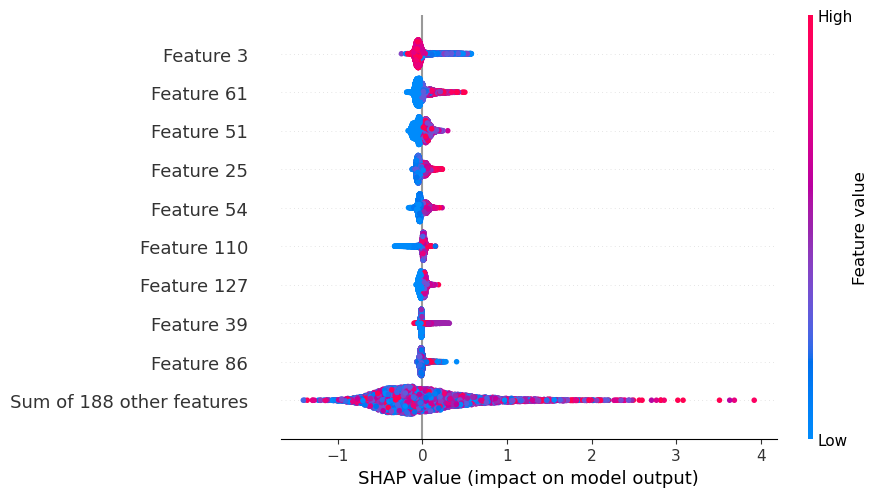

In [231]:
shap.plots.beeswarm(shap_values)

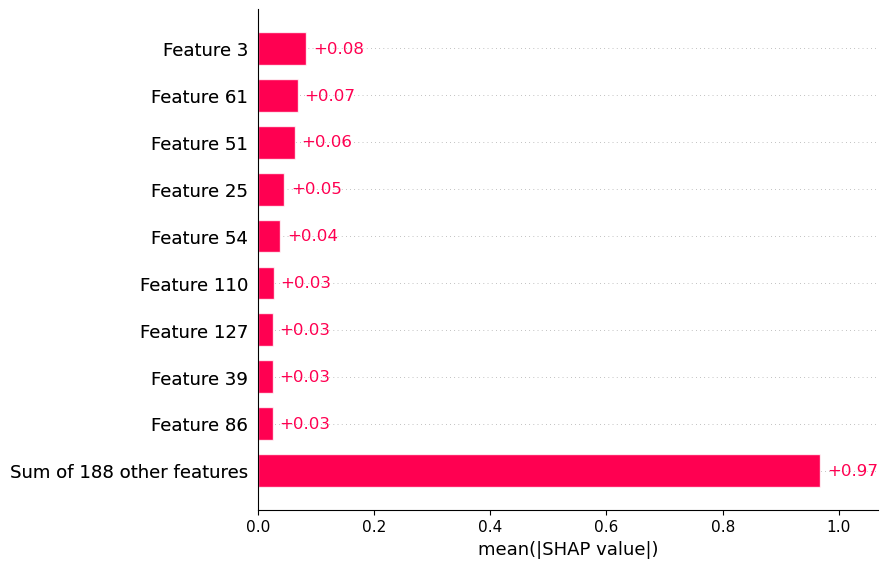

In [232]:
shap.plots.bar(shap_values)